In [30]:
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
from pysurvival.utils.display import correlation_matrix
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from pysurvival.models.semi_parametric import NonLinearCoxPHModel
from pysurvival.models.semi_parametric import CoxPHModel
from pysurvival.models.multi_task import LinearMultiTaskModel
from pysurvival.utils.display import compare_to_actual
from pysurvival.utils.display import display_loss_values


In [3]:
raw_dataset = pd.read_csv('Telco-Customer-Churn.csv')
raw_dataset.shape

(7043, 21)

In [4]:
raw_dataset.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
raw_dataset.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

# One line EDA

In [8]:
raw_dataset.profile_report()

# Build and split dataset

In [7]:
categories = ['Churn', 'Contract', 'Dependents','DeviceProtection', 'gender', 'InternetService', 
              'MultipleLines', 'OnlineBackup', 'OnlineSecurity', 'PaperlessBilling', 'Partner',
             'PaymentMethod', 'PhoneService', 'SeniorCitizen', 'StreamingMovies', 'StreamingTV', 'TechSupport']
time_column = 'tenure'
event_column = 'Churn_Yes'

dataset = pd.get_dummies(raw_dataset, columns=categories, drop_first=True)
dataset.drop(columns=['customerID'], inplace=True)
dataset['TotalCharges'] = pd.to_numeric(dataset['TotalCharges'], errors='coerce')

features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

# Checking for null values
dataset = dataset.dropna().reset_index( drop = True )

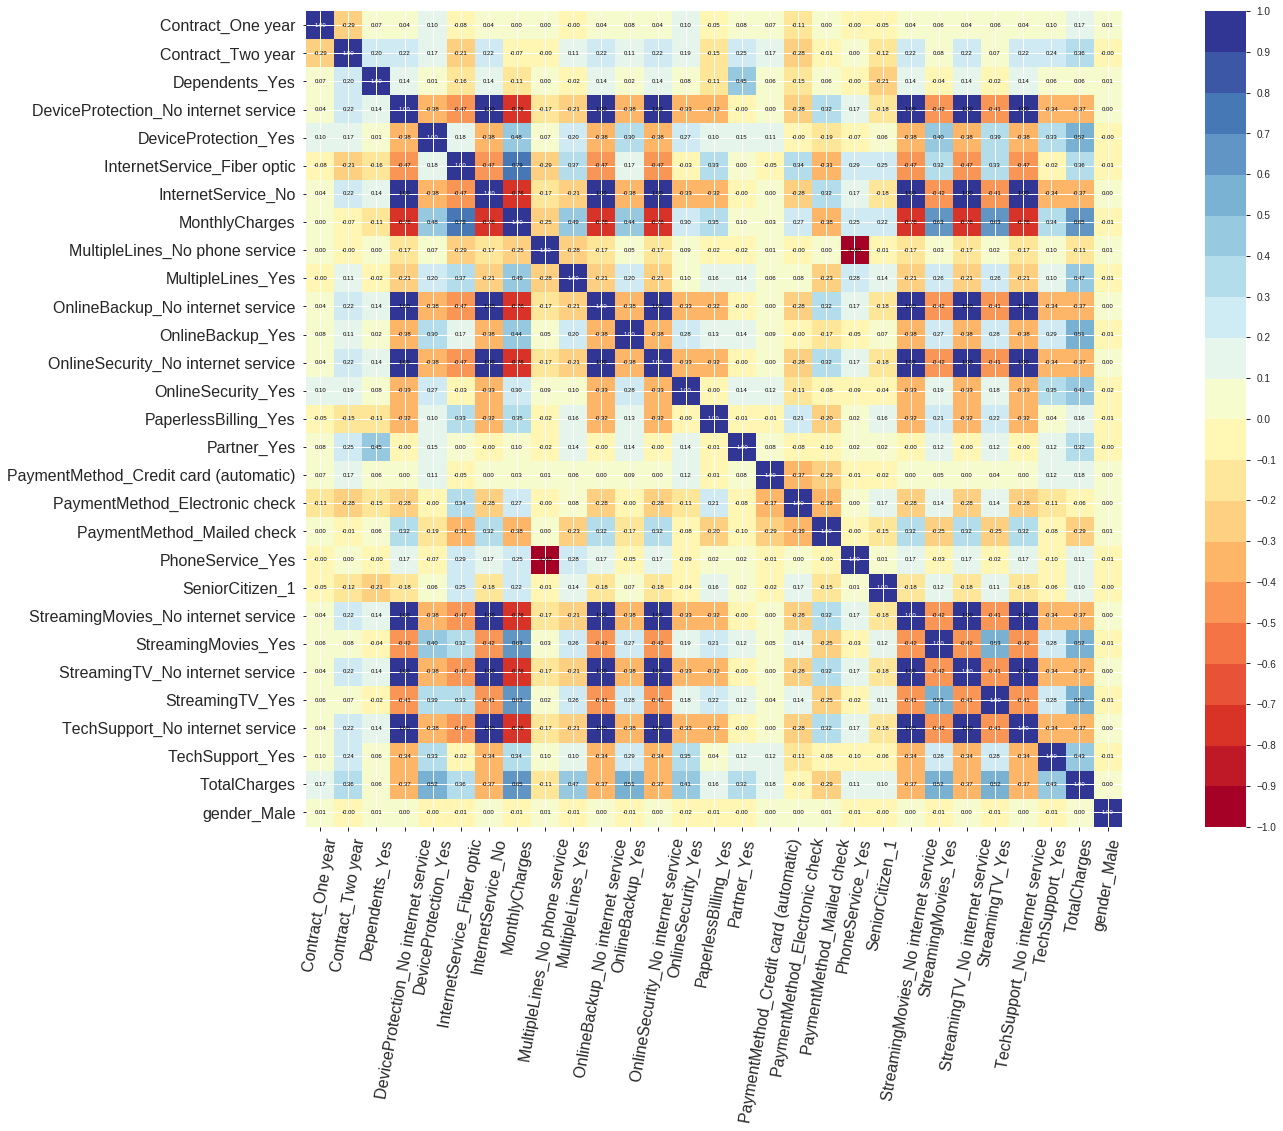

In [148]:
correlation_matrix(dataset[features], figure_size=(30,15), text_fontsize=6)

In [8]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=44)
split = list(split.split(dataset[features], dataset[event_column]))


data_train = dataset.loc[split[0][0]].reset_index( drop = True )
data_test  = dataset.loc[split[0][1]].reset_index( drop = True )

X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

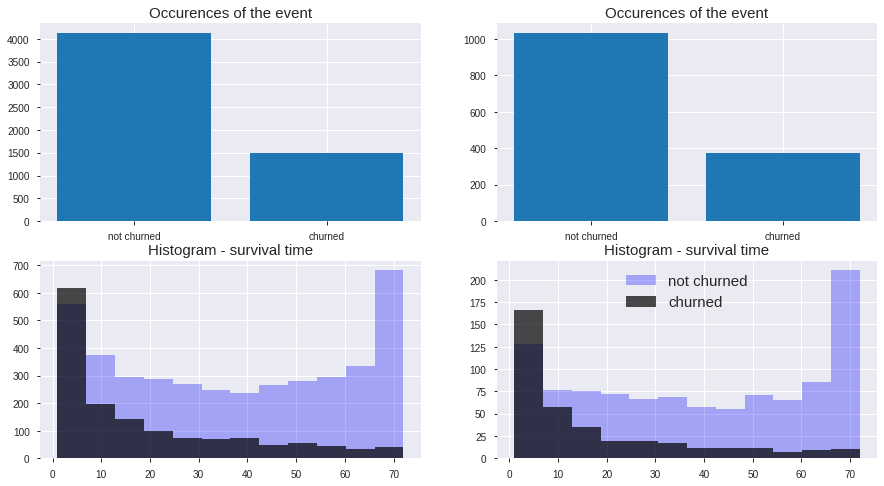

In [9]:
fig, ((ax1, ax2)) = plt.subplots(2, 2,  figsize=(15, 8))

data = Counter(E_train.replace({0:'not churned', 1:'churned'}))
counts = list(data.values())
idx = range(len(counts))

ax1[0].bar(idx, counts)
ax1[0].set_xticks(idx)
ax1[0].set_xticklabels(list(data.keys()))
ax1[0].set_title( 'Occurences of the event', fontsize=15)

data = Counter(E_test.replace({0:'not churned', 1:'churned'}))
counts = list(data.values())
idx = range(len(counts))

ax1[1].bar(idx, counts)
ax1[1].set_xticks(idx)
ax1[1].set_xticklabels(list(data.keys()))
ax1[1].set_title( 'Occurences of the event', fontsize=15)

time_0 = T_train.loc[E_train == 0]
ax2[0].hist(time_0, bins=12, alpha=0.3, color='blue', label = 'not churned')

time_1 = T_train.loc[E_train == 1]
ax2[0].hist(time_1, bins=12, alpha=0.7, color='black', label = 'churned')
ax2[0].set_title( 'Histogram - survival time', fontsize=15)

time_0 = T_test.loc[E_test == 0]
ax2[1].hist(time_0, bins=12, alpha=0.3, color='blue', label = 'not churned')

time_1 = T_test.loc[E_test == 1]
ax2[1].hist(time_1, bins=12, alpha=0.7, color='black', label = 'churned')
ax2[1].set_title( 'Histogram - survival time', fontsize=15)

plt.legend(fontsize=15)
plt.show()

# Model 🚀

C-index: 0.88


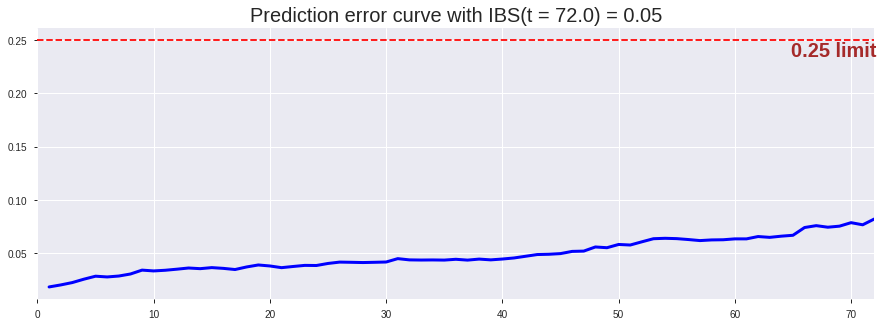

IBS: 0.05


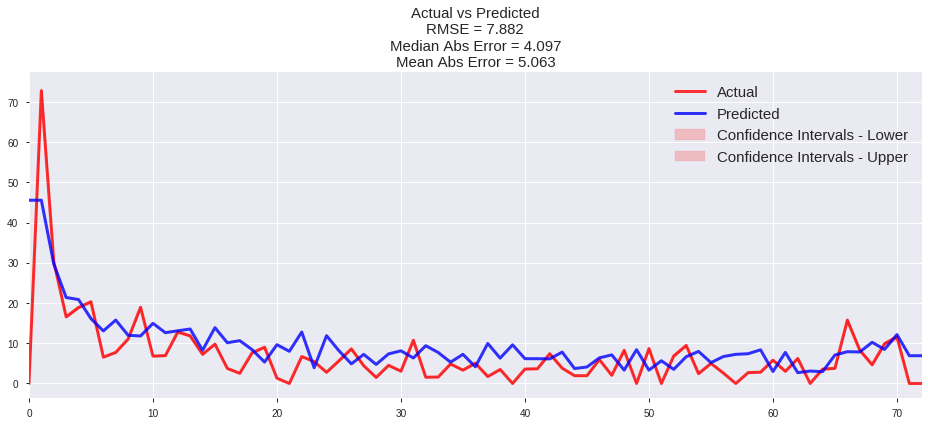

In [10]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fitting the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='all',
        max_depth=10, min_node_size=10, alpha=0.05, minprop=0.1)

c_index = concordance_index(csf, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(csf, X_test, T_test, E_test, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

results = compare_to_actual(csf, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

In [67]:
type(csf.predict_survival(X_test, T_test))

numpy.ndarray

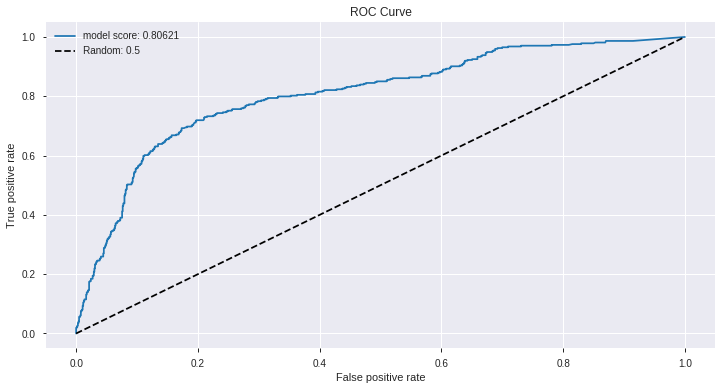

In [35]:
scores = 1 - csf.predict_survival(X_test, T_test)
auc_test = roc_auc_score(E_test, scores)
fpr_test, tpr_test, tresholds = roc_curve(E_test, scores)
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_test, tpr_test, label = 'model score: ' + str(round(auc_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [146]:
csf.variable_importance_table.head(10)

,feature,importance,pct_importance
0,TotalCharges,71.968930,0.374226
1,Contract_Two year,25.186889,0.130967
2,Contract_One year,21.801571,0.113364
3,InternetService_Fiber optic,13.450139,0.069938
4,MonthlyCharges,7.078302,0.036806
5,StreamingMovies_Yes,6.360993,0.033076
6,StreamingTV_No internet service,5.292396,0.027520
7,StreamingMovies_No internet service,5.034252,0.026177
8,InternetService_No,4.580838,0.023820
9,OnlineBackup_No internet service,4.438278,0.023078


# Deep model


In [74]:
import torch
torch.cuda.set_device(0)

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 12170.144 - ||grad||^2 = 3097.44659
 * Iteration #2 - Loss = 10802.588 - ||grad||^2 = 1523.75321
 * Iteration #3 - Loss = 10348.416 - ||grad||^2 = 903.75456
 * Iteration #4 - Loss = 10074.395 - ||grad||^2 = 538.25179
 * Iteration #5 - Loss = 9914.158 - ||grad||^2 = 314.30828
 * Iteration #6 - Loss = 9832.625 - ||grad||^2 = 178.20603
 * Iteration #7 - Loss = 9797.764 - ||grad||^2 = 97.90371
 * Iteration #8 - Loss = 9785.121 - ||grad||^2 = 52.23987
 * Iteration #9 - Loss = 9781.104 - ||grad||^2 = 27.22162
 * Iteration #10 - Loss = 9779.942 - ||grad||^2 = 13.94567
 * Iteration #11 - Loss = 9779.626 - ||grad||^2 = 7.06710
 * Iteration #12 - Loss = 9779.544 - ||grad||^2 = 3.55874
 * Iteration #13 - Loss = 9779.522 - ||grad||^2 = 1.78590
 * Iteration #14 - Loss = 9779.517 - ||grad||^2 = 0.89461
 * Iteration #15 - Loss = 9779.515 - ||grad||^2 = 0.44772
 * Iteration #16 - Loss = 9779.515 - ||grad||^2 = 0.22397
 * Iteration #17 - L

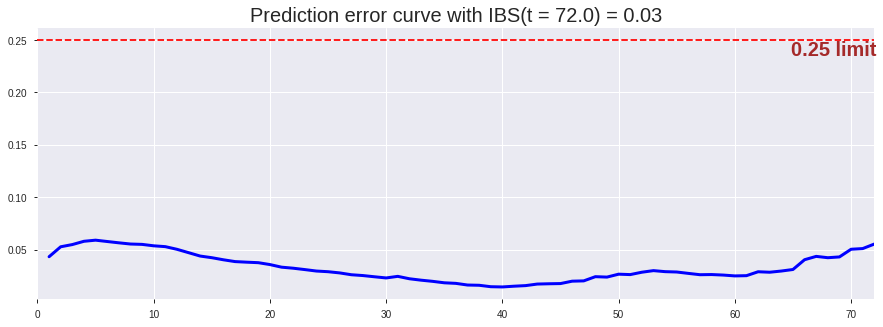

IBS: 0.03


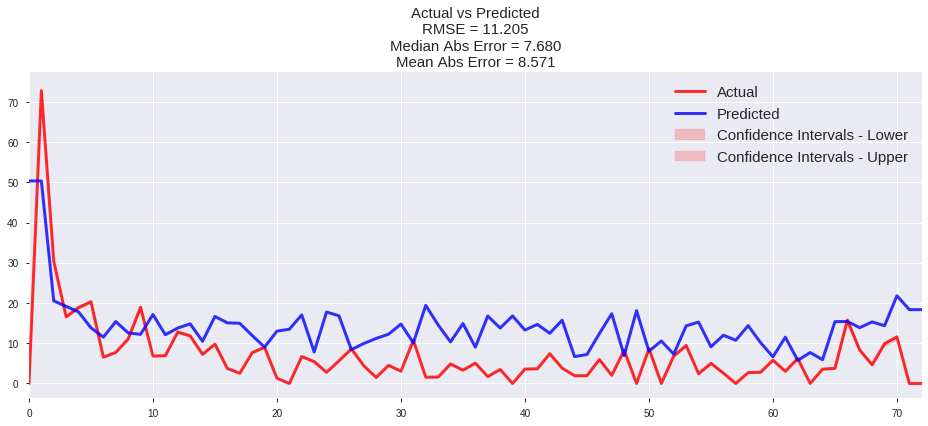

In [71]:
coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.5, l2_reg=1e-2, init_method='zeros')


c_index = concordance_index(coxph, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(coxph, X_test, T_test, E_test, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

results = compare_to_actual(coxph, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

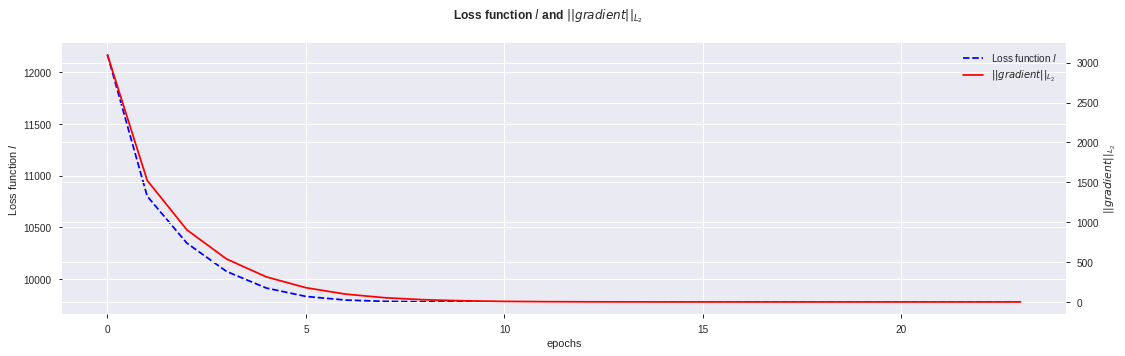

In [72]:
display_loss_values(coxph)

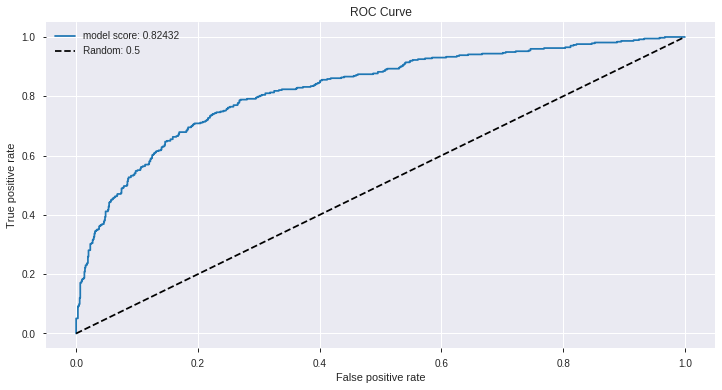

In [73]:
scores = 1 - coxph.predict_survival(X_test, T_test)
auc_test = roc_auc_score(E_test, scores)
fpr_test, tpr_test, tresholds = roc_curve(E_test, scores)
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_test, tpr_test, label = 'model score: ' + str(round(auc_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

# MLTR


% Completion: 100%|**********************************************|Loss: 4589.99


C-index: 0.90


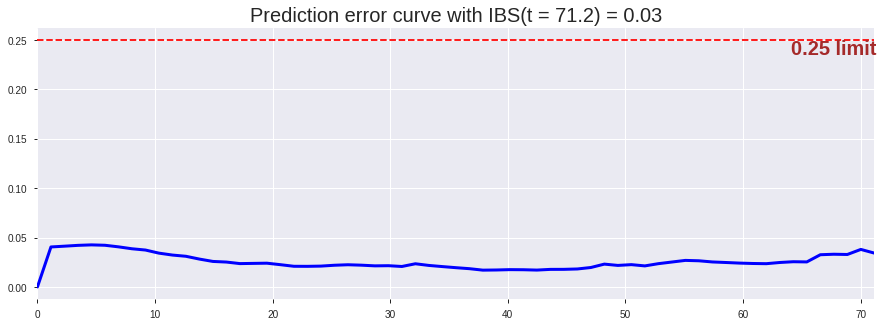

IBS: 0.03


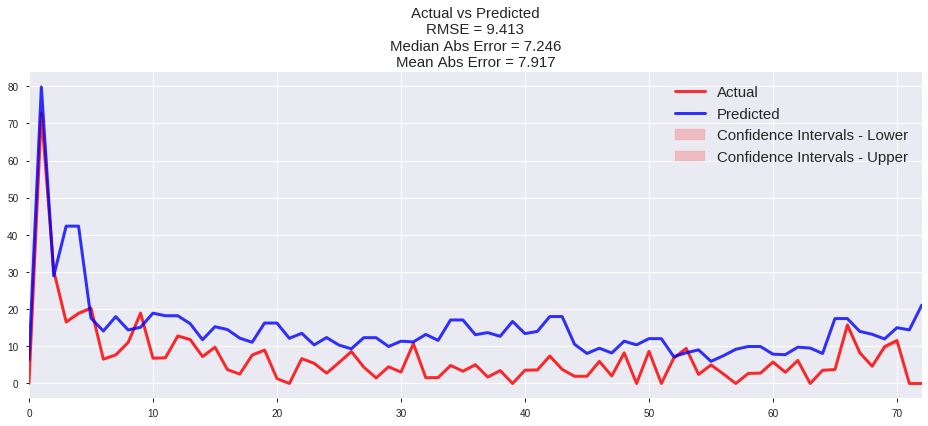

In [75]:
l_mtlr = LinearMultiTaskModel(bins=70)
l_mtlr.fit(X_train, T_train, E_train, lr=1e-4, init_method='orthogonal', num_epochs=5000)

c_index = concordance_index(l_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

ibs = integrated_brier_score(l_mtlr, X_test, T_test, E_test, figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

results = compare_to_actual(l_mtlr, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

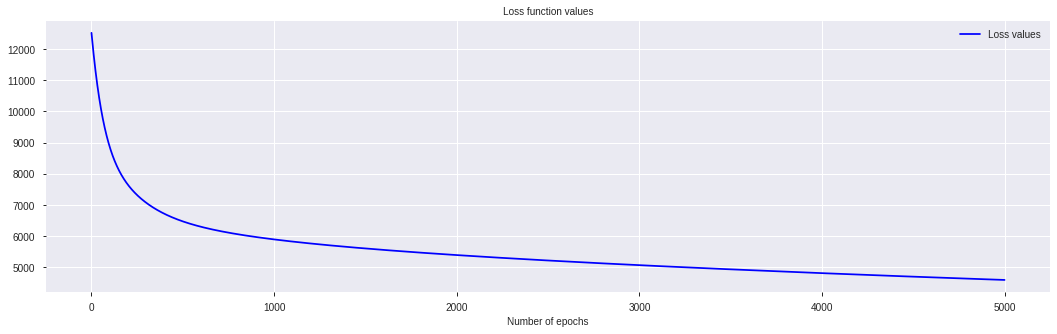

In [76]:
display_loss_values(l_mtlr)

In [77]:
scores = []
for i in range(1407):
    scores.append(l_mtlr.predict_survival(X_test.iloc[i], T_test.iloc[i])[0])

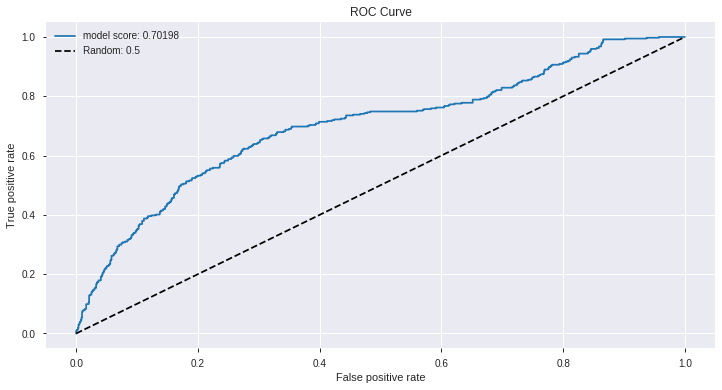

In [78]:
scores = 1 - np.asarray(scores)
auc_test = roc_auc_score(E_test, scores)
fpr_test, tpr_test, tresholds = roc_curve(E_test, scores)

plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_test, tpr_test, label = 'model score: ' + str(round(auc_test, 5)))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()